In [1]:
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from dataset.construct import ImageDataset
from dataset.library import DATASETS
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE


dataset_name, n_classes = DATASETS["Common"][1]
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


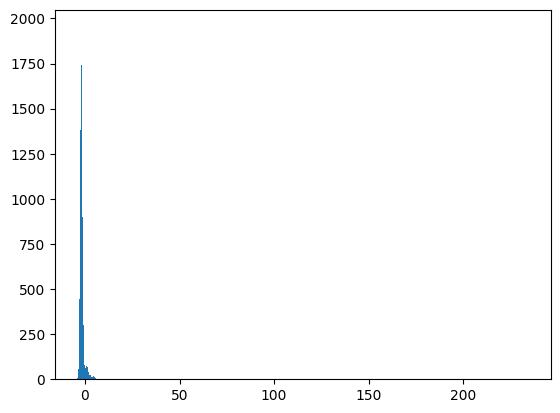

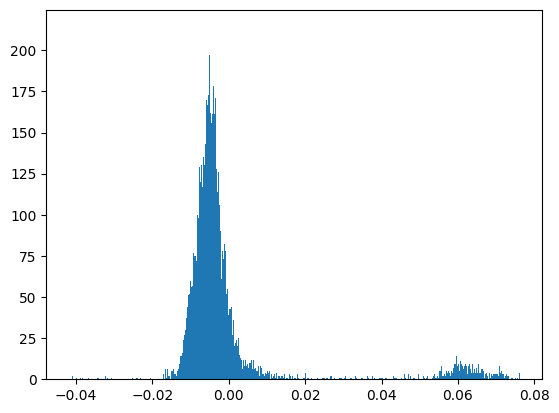

In [2]:
%matplotlib inline
from ncut_pytorch import NCUT

from modeling.image_features import ImageFeatures
from modeling.openclip_vit import OpenCLIPViT
from modeling.vit_extraction import OpenCLIPExtractionViT
from visualize.base import construct_per_layer_output_dict


def ncut_pre_hook(t: torch.Tensor) -> torch.Tensor:
    num_eig = 100
    ncut = NCUT(num_eig=num_eig, distance="rbf", indirect_connection=False, device=DEVICE)
    return ncut.fit_transform(t.flatten(0, -2))[0].unflatten(0, t.shape[:-1])

def norm_post_hook(t: torch.Tensor) -> torch.Tensor:
    return torch.norm(t[..., :2], p=2, dim=-1)

conditions = {
    # 10: {
    #     "condition": lambda t: t > 0.0118,
    #     "pre_hook": ncut_pre_hook,
    #     "post_hook": norm_post_hook,
    # },
    12: {
        "name": "MA",
        "condition": lambda t: t > 25.0,
        # "condition": lambda t: t < -25.0
    },
    # 16: {
    #     "condition": lambda t: t > 7.5
    # },
    15: {
        "name": "Artifact",
        "pre_hook": ncut_pre_hook,
        "condition": lambda t: t > 0.015,
        # "condition": lambda t: t < -0.015,
    },
    # 16: {
    #     "condition": lambda t: t < -7.5,
    # },
}
mode = "mean_concatenation"
model = OpenCLIPExtractionViT(mode, conditions)
original_model = OpenCLIPViT()

def residual_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return input_ + tree_flatten(output_)[0][0]
    
def input_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return tree_flatten(input_)[0][0]

def weight_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return model_.weight.mT

def get_weight_by_name(name: str) -> Callable[[nn.Module, Any, Any], Any]:
    def hook(model_: nn.Module, input_: Any, output_: Any) -> Any:
        return utils.rgetattr(model_, name).data
    return hook

def attention_proj_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return tree_flatten(input_)[0][0] @ model_.in_proj_weight.mT + model_.in_proj_bias

def attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return einops.rearrange(
        model_.forward(*input_, attn_mask=None, need_weights=True, average_attn_weights=False)[1][..., :ImageFeatures.N + 1, :ImageFeatures.N + 1],
        "n ... h w -> n h w ..."
    ).to(OUTPUT_DEVICE)
    # return einops.rearrange(
    #     tree_flatten(output_)[0][0],
    #     "b h n1 n2 -> b n1 n2 h"
    # ).to(OUTPUT_DEVICE)

def query_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    QKVw = model_.in_proj_weight
    QKVb = model_.in_proj_bias
    
    D = 1024
    Qw, Qb = QKVw[:D], QKVb[:D]
    Q = utils.linear_from_wb(Qw, Qb)
    return Q.forward(tree_flatten(input_)[0][0]).to(OUTPUT_DEVICE)

def key_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    QKVw = model_.in_proj_weight
    QKVb = model_.in_proj_bias
    
    D = 1024
    Kw, Kb = QKVw[D:2 * D], QKVb[D:2 * D]
    K = utils.linear_from_wb(Kw, Kb)
    return K.forward(tree_flatten(input_)[0][0]).to(OUTPUT_DEVICE)

def value_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    QKVw = model_.in_proj_weight
    QKVb = model_.in_proj_bias
    
    D = 1024
    Vw, Vb = QKVw[2 * D:], QKVb[2 * D:]
    V = utils.linear_from_wb(Vw, Vb)
    return V.forward(tree_flatten(input_)[0][0]).to(OUTPUT_DEVICE)


monitor_config = OrderedDict({
    "model.visual.transformer.resblocks": OrderedDict({
        "": [
            # ("layer_input", input_hook_fn),
            ("layer_output", Monitor.default_hook_fn),
        ],
        # "ln_1": "layer_norm1_output",  # "norm1"
        # "attn": [
        #     # ("attention_input", input_hook_fn),
        #     # ("query", query_hook_fn),
        #     # ("key", key_hook_fn),
        #     ("value", value_hook_fn),
        #     # ("attention_proj", attention_proj_hook_fn),
        #     # ("attention_output", Monitor.default_hook_fn),
        #     # ("attention_matrix", attention_matrix_hook_fn),
        # ],
        # "ln_2": [
        #     ("intermediate_output", input_hook_fn),
        #     ("layer_norm2_output", Monitor.default_hook_fn),  # "norm2"
        # ],
        # "mlp": {
        #     "": "mlp_output",
        #     "c_fc": [
        #         # ("mlp_fc1_input", input_hook_fn),
        #         # ("mlp_fc1_output_no_bias", fc_no_bias_hook_fn),
        #         ("mlp_fc1_output", Monitor.default_hook_fn),
        #         # ("mlp_fc1_weight", weight_hook_fn),
        #     ],
        #     "gelu": [
        #         ("mlp_activation_output", Monitor.default_hook_fn),
        #     ],
        #     # "c_proj": "mlp_fc2",
        # }
    })
})

model = model.to(DEVICE)
monitor = Monitor(model, monitor_config)
model_weights = Monitor(model, OrderedDict({
    "model.visual.transformer.resblocks.attn": OrderedDict({
        # "": [
        #     ("QKVw", get_weight_by_name("in_proj_weight")),
        #     ("QKVb", get_weight_by_name("in_proj_bias")),
        #     ("out_w", get_weight_by_name("out_proj.weight")),
        #     ("out_b", get_weight_by_name("out_proj.bias")),
        # ],
    }),
}))

# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))

torch.set_default_device(DEVICE)
per_metric_output_dict = monitor.reset()
model_dict = model_weights.reset()
with torch.no_grad():
    output = model.forward(images)
    # original_output = original_model(images)

per_layer_output_dict = construct_per_layer_output_dict(per_metric_output_dict)
model_dict = [
    dict(zip(model_dict.keys(), next(zip(*v))))
    for v in zip(*model_dict.values())
]
    

In [3]:
# torch.set_printoptions(linewidth=400, sci_mode=False)

# def profile(name: str, relative_error: torch.Tensor) -> None:
#     print(f"{name} --- max: {relative_error.max().item()}, mean: {relative_error.mean().item()}, min: {relative_error.min().item()}")

# re = torch.abs(output[0][0] / original_output[0] - 1)
# ae = torch.abs(output[0][0] - original_output[0])

# profile(f"{mode} relative error", re)
# profile(f"{mode} absolute error", ae)

# print(ae)
# print(original_output[0])

In [4]:
# SECTION: Visualize original images
%matplotlib inline
from core.attention_sink import massive_token_heuristic
from modeling.image_features import ImageFeatures
from visualize.base import visualize_images_with_mta, get_rgb_colors
from visualize.attention import compute_attention_contribution

torch.set_default_device(OUTPUT_DEVICE)

# SECTION: Massive token heuristic
if isinstance(output, tuple):
    mta_masks: Dict[str, torch.Tensor] = {
        k: torch.load(f"experiments/saved_masks/{k}_mask{batch_size}.pt", map_location=OUTPUT_DEVICE)
        for k in ("MA", "AS")
    }
    # mta_masks: Dict[int, torch.Tensor] = {k: v.to(OUTPUT_DEVICE) for k, v in output[1].items()}
else:
    layer_idx = 15
    mta_masks: Dict[str, torch.Tensor] = {"MA": massive_token_heuristic(layer_idx, per_metric_output_dict).to(OUTPUT_DEVICE)}

for k, v in mta_masks.items():
    print(f"{k}: {v.sum().item()}/{v.numel()}")

# features = ImageFeatures(per_layer_output_dict, mta_masks, mode, DEVICE)
features = ImageFeatures(per_layer_output_dict, {}, mode, DEVICE)

# # Update ImageFeatures data structure with attention contributions
# attention_contributions = [
#     compute_attention_contribution(features, layer_idx, model_dict, mta_masks)
#     for layer_idx in range(features.num_layers)
# ]
# for k, alias in mta_aliases.items():
#     features.update(("attention_contribution", alias), torch.stack([
#         attention_contribution[k].to(OUTPUT_DEVICE)
#         for attention_contribution in attention_contributions
#     ], dim=0))

# # Visualize images
# for mask in mta_masks.values():
#     visualize_images_with_mta(original_images.to(OUTPUT_DEVICE), mask.to(OUTPUT_DEVICE))

try:
    rgb_assignment
except NameError:
    rgb_fname = "sandbox/rgb_assignment.pt"
    if not os.path.exists(rgb_fname):
        color_layer_idx = 10    # min(mta_masks.keys())
        rgb_assignment = get_rgb_colors(features, color_layer_idx, "layer_output", False)
        torch.save(rgb_assignment, rgb_fname)
    else:
        rgb_assignment = torch.load(rgb_fname, map_location=OUTPUT_DEVICE)

# # highlight = torch.LongTensor((
# #     (1, 5, 4),
# #     (4, 15, 8),
# # ))
# highlight = torch.load("./sandbox/artifact_indices.pt")

MA: 129/12850
AS: 1556/12850


In [18]:
# SECTION: Per image visualization code
%matplotlib inline
from visualize.base import (
    visualize_features_per_image,
    visualize_feature_norms_per_image,
)
from visualize.attention import (
    compute_attention_contribution,
    visualize_attention_matrix_per_image,
    visualize_attention_weights_from_ma_per_image,
    visualize_incoming_attention_per_image,
    visualize_attention_to_MA_per_image,
    visualize_attention_from_CLS_per_image,
    visualize_attention_weights_per_image,
)
from visualize.projections import (
    visualize_qk_projection_per_image,
    visualize_qk_projection_per_image2,
    visualize_pc_projection_per_image,
    visualize_feature_values_by_pca,
)

# for layer_idx in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
# for layer_idx in [13]:
for layer_idx in [11, 12, 13, 14, 15, 16, 17, 18]:
    print(f"Layer {layer_idx} {'=' * 120}")
    output_dict = per_layer_output_dict[layer_idx]
    
    # min_cutoff_idx = min((float("inf"), *filter(lambda l: l >= layer_idx, mta_masks.keys())))
    # mask = mta_masks.get(min_cutoff_idx, None)
    mask = mta_masks["MA"]
    
    # for sk, alias in mta_aliases.items():
    #     visualize_feature_norms_per_image(features, layer_idx, ("attention_contribution", alias), cmap="gray")
    #     visualize_features_per_image(
    #         features, layer_idx, ("attention_contribution", alias),
    #         mask, use_all=False, highlight=None,
    #     )
    
    # def rank_k(k: int) -> Callable[[torch.Tensor], torch.Tensor]:
    #     def fn(A: torch.Tensor) -> torch.Tensor:
    #         utils.reset_seed()
    #         # U, S, V = torch.svd_lowrank(torch.log(A), q=100)
    #         # return torch.softmax((U[:, k:k + 1] * S[k:k + 1]) @ V[:, k:k + 1].mT, dim=1)
    #         U, S, V = torch.svd_lowrank(A, q=100)
    #         return (U[:, k:k + 1] * S[k:k + 1]) @ V[:, k:k + 1].mT
    #     fn.__name__ = f"rank{k}"
    #     return fn
    
    # attention_matrix: torch.Tensor = output_dict["attention_matrix"]
    # visualize_attention_matrix_per_image(
    #     layer_idx, attention_matrix, mta_masks, transform_func=None, per_head=True,
    #     rescale_func=lambda t: torch.log2(t + 1), subsample=1.0, cmap="viridis", cmap_scale="arcsinh",
    # )
    # visualize_attention_to_MA_per_image(layer_idx, attention_matrix, mta_masks["MA"], exclude_self=False, per_head=True)
    # visualize_attention_from_CLS_per_image(layer_idx, attention_matrix, mta_masks["MA"] + mta_masks["AS"], exclude_MA=True, per_head=False)
    # for k in range(3):
    #     visualize_attention_matrix_per_image(
    #         features, layer_idx, mta_aliases, transform_func=rank_k(k), per_head=False,
    #         rescale_func=lambda t: torch.log2(t + 1), cmap_scale="linear", subsample=1.0, cmap="viridis",
    #     )
    # visualize_attention_matrix_per_image(
    #     features, layer_idx, mta_aliases, rank_approximation=3, per_head=False,
    #     rescale_func=lambda t: torch.log2(t + 1), cmap="viridis",
    # )
    # visualize_attention_weights_from_ma_per_image(features, layer_idx, mta_masks, mta_aliases, cmap="viridis")
    # visualize_incoming_attention_per_image(features, layer_idx, cmap="gray")
    
    # visualize_attention_weights_per_image(
    #     features, layer_idx, mta_masks, mta_aliases, ("linear", 2), rgb_assignment,
    #     per_head=False,
    # )
    
    # visualize_feature_norms_per_image(features, layer_idx, "mlp_output", cmap="gray")
    # visualize_pc_projection_per_image(features, layer_idx, "attention_input", modes=[
    #     ("linear", 0),
    #     ("ncut", 0),
    #     ("ncut", 1),
    # ])
    # visualize_feature_norms_per_image(features, layer_idx, "query", cmap="gray")
    # visualize_feature_norms_per_image(features, layer_idx, "key", cmap="gray")
    
    for metric_name in (
        # "layer_norm1_output",
        # "query",
        # "key",
        # "value",
        # "attention_output",
        # "intermediate_output",
        # "layer_norm2_output",
        # "mlp_fc1_output",
        # "mlp_activation_output",
        # "mlp_output",
        "layer_output",
    ):
        # continue
        # visualize_feature_norms_per_image(
        #     features,
        #     layer_idx,
        #     metric_name,
        #     cmap="gray",
        # )
        visualize_features_per_image(
            features,
            layer_idx,
            metric_name,
            mta_mask=None,  # mask,
            use_all=False,
            highlight=None, # highlight,
        )
        # visualize_feature_norms_per_image(features, layer_idx, metric_name, cmap="gray")
        # visualize_qk_projection_per_image(output_dict)
        # continue
        # visualize_pc_projection_per_image(features, layer_idx, metric_name, modes=[
        #     ("linear", 0),
        #     ("linear", 1),
        #     # ("ncut_pca", 0),
        #     # ("ncut_pca", 1),
        #     # ("ncut_pca", 2),
        #     # ("ncut_pca", 3),
        #     # ("recursive_ncut", 0),
        #     # ("recursive_ncut", 1),
        #     # ("axis_align_norm", 0),
        #     # ("axis_align_norm", 1),
        #     # ("axis_align_norm", 2),
        #     # ("axis_align_norm", 3),
        #     # ("axis_align_norm", 4),
        #     # ("axis_align_norm", 5),
        #     # ("ncut", 0),
        #     # ("ncut", 1),
        #     # ("ncut", 2),
        #     # ("ncut", 3),
        # ])
     
        
    # # visualize_feature_norms_per_image("attention_input", output_dict["attention_input"], cmap="pink")
    # # visualize_feature_norms_per_image("attention_proj", output_dict["attention_proj"], cmap="viridis")
    
    continue
    visualize_qk_projection_per_image(
        features, layer_idx, model_dict, 
        p=0.0, aggregate_func=torch.mean,
    )
    
    # # visualize_projections_per_image(output_dict, aggregate_func=lambda t: torch.median(t, dim=-2).values, aggregate_name="median")
    # # visualize_projections_per_image(output_dict, aggregate_func=lambda t: torch.max(t, dim=-2).values, aggregate_name="max")
    # visualize_feature_norms_per_image("attention_output", output_dict["attention_output"], cmap="bone")
raise Exception()

Layer 11 ========================================================================================================================


AssertionError: asdfuiopqwer, 11

In [ ]:
# SECTION: Comparison of linear projections between layers
%matplotlib inline
from visualize.projections import compare_pc_projection_across_layers

compare_pc_projection_across_layers(features, 10, 11, "layer_output", rgb_assignment, mode=("linear", 0), highlight=torch.argwhere(mta_masks[12]))
raise Exception()


In [ ]:
# # SECTION: Per layer visualization code
# %matplotlib inline
# from core.visualize import visualize_feature_norms_per_layer

# include = ["layer_output"]
# for metric in include:
#     stacked_metric_output = stacked_layer_output_dict[metric]
#     visualize_feature_norms_per_layer(metric, stacked_metric_output, mta_mask, mta_indices, rgb_assignment, fns={
#         "norm": lambda t: torch.norm(t, p=2, dim=-1),
#         "inf_norm": lambda t: torch.norm(t, p=torch.inf, dim=-1),
#         "max": lambda t: torch.max(t, dim=-1).values,
#     })

In [ ]:
# SECTION: Histogram value visualization
%matplotlib inline
from visualize.projections import visualize_feature_values_by_pca

include = {
    "mlp_fc1_input": {"align_layers": True},
    "mlp_fc1_output": {"fn": lambda t: torch.mean(t, dim=0), "align_layers": False},
    # "mlp_fc1_output_no_bias": {"fn": lambda t: torch.mean(t, dim=0), "align_layers": False},
}
# include = {"layer_norm2_input", "layer_norm2_output"}
# for metric, metric_kwargs in include.items():
#     visualize_feature_values_by_channel(metric, stacked_layer_output_dict[metric], **metric_kwargs)


# cutoff_layer = min(mta_masks.keys())
for layer_idx in range(13, 24):
# for layer_idx in [7]:
    print(f"Layer {layer_idx} {'=' * 120}")
    # min_cutoff_idx = min((float("inf"), *filter(lambda l: l >= layer_idx, mta_masks.keys())))
    # # min_cutoff_idx = min((float("inf"), *filter(lambda l: l > min_cutoff_idx, mta_masks.keys())))
    # mask = mta_masks.get(min_cutoff_idx, None)
    for metric_name in (
        # "attention_input",
        # "query",
        # "key",
        "layer_norm1_output",
        # "attention_output",
        # "intermediate_output",
        # "layer_norm2_output",
        # "mlp_fc1_output",
        # "mlp_activation_output",
        # "mlp_output",
        # "layer_output",
    ):
        visualize_feature_values_by_pca(
            features,
            layer_idx,
            metric_name,
            {"linear"},   # {"linear", "ncut", "recursive_ncut"},
            None,   # mta_masks,
            rgb_assignment,
            ndim=2,
            with_cls=True,
            highlight=None,
            alpha=1.0,
        )
    # visualize_feature_norms_by_channel(metric, stacked_layer_output_dict[metric], mta_mask)

# visualize_fc_weights(stacked_layer_output_dict["mlp_fc1_input"], stacked_layer_output_dict["mlp_fc1_weight"], mta_mask, mean="local")